<a href="https://colab.research.google.com/github/simonabisiani/chatgpt_employment/blob/main/ChatGPT_employment_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ChatGPT and employment project
*Authors: Simona Bisiani, Al-Hussein Abutaleb*

The purpose of this notebook is to perform and evaluate a text analysis of tweets relating to ChatGPT and employment. The project sits within research conducted at the Surrey Institute for Artificial Intelligence by Dr Eddy Zhu and Dr Erin Ling. 

The notebook includes the following sections:
- data collection (this is not to be re-run, it's only included for transparency purposes)
- summary statistics and characteristics of the data
- topic modeling
- sentiment analysis

The necessary data for processing code in this notebook can be found at this [GitHub repository](https://github.com/simonabisiani/chatgpt_employment). We will use the code below to load the data in the notebook.

In [1]:
# LOADING THE DATA
!git clone https://github.com/simonabisiani/chatgpt_employment.git

Cloning into 'chatgpt_employment'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 56 (delta 16), reused 24 (delta 2), pack-reused 0
Unpacking objects: 100% (56/56), 6.13 MiB | 2.21 MiB/s, done.
Filtering content: 100% (2/2), 141.96 MiB | 31.82 MiB/s, done.


In [4]:
!pip install rpy2==3.5.1   # needed to run R code in colab; restart runtime after running this chunk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 KB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp38-cp38-linux_x86_64.whl size=318376 sha256=1e2f498b0bed0bb4feb22b8c28a4026b82b8f3142275b63f3c21a26dc806aa35
  Stored in directory: /root/.cache/pip/wheels/6b/40/7d/f63e87fd83e8b99ee837c8e3489081c4b3489134bc520235ed
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5


In [2]:
%load_ext rpy2.ipython

# this command allows us to run both R and Python code throughout the notebook. 
#Whenever we need to run R code, we simply need to include %%R at the beginning of the code chunk

## Data collection
Upon recommendations from Dr Ling, we queried Twitter for tweets relating to search **chatgpt** *AND* any of the following words:
**"employment", "employability", "employer","employee", "unemployment",      "unemployed", "job", "work", "skill", "taking over", "replace human", "performance", "concern", "insecurity", "fear", "threat", "opportunities", "training","creation", "displacement", "occupation", "earning","future demand",
"education", "labour", "labor", "task", "industry", "workforce", "shortage","collaboration", "collaborate", "human ai team", "team", "economic", "economy"** 

On 24th February we collected, using the Twitter API and the R package *academictwitteR*, any tweets containing our query **between 30th November 2022 and 24th February 2023**. The data collection was only possible through an Academic Twitter API developer account, due to: the number of tweets wanted, and the possibility to search the full archive. With a standard developer account (e.g. Elevated), this would have not been possible.

The code we wrote to collect the data is this:

```
chatgpt_full_collection <- data.frame()
and <- "chatgpt"
or <- c("employment",
        "employability",
        "employer",
        "employee",         
        "unemployment",
        "unemployed",
        "job", 
        "work",
        "skill",
        "taking over",
        "replace human",
        "performance",
        "concern",
        "insecurity",
        "fear",
        "threat",
        "opportunities",
        "training",
        "creation", 
        "displacement", 
        "occupation",
        "earning", 
        "future demand",
        "education",
        "labour",
        "labor", 
        "task", 
        "industry",
        "workforce",
        "shortage", 
        "collaboration", 
        "collaborate", 
        "human ai team",
        "team",
        "economic", 
        "economy")

queries <- paste(and, or)

for (i in queries) {
  iteration_i <- get_all_tweets(
    query = i,
    start_tweets = "2022-11-30T00:00:00Z",
    end_tweets = "2023-02-24T00:00:00Z",
    n = Inf,
    bearer_token = bearer_token, # NOTE! the bearer token is not included in this notebook, making this code chunk impossible to run unless in possession of a Twitter API Academic account
    data_path = "chatgpt_full_collection/")
  iteration_i$query <- i  
  chatgpt_full_collection <- bind_rows(chatgpt_full_collection, iteration_i)}

saveRDS(chatgpt_full_collection, "chatgpt_full_collection.RDS")
data <- readRDS("chatgpt_full_collection.RDS")
tweets <- data %>% select(text, query, created_at, author_id)

file <- toJSON(tweets)
write(file, "full_dataset_chatgpt.json")
```



There is little knowledge on query formulation on Twitter. Our **assumption** was **that the singular form of the word** (or its canonical form) **would return** tweets containing **the plural form too**. However, using another function from the academictwitteR package, which allows us to check for the number of tweets resulting from a query without needing to download the data, we found out **this appears not to be true**.

We ran the code below to obtain the number of tweets for each of the singular/plural pairs, and saved the data. Let's load the data in the notebook so we can visualise the differences in counts between singular/plural queries.

```
and <- "chatgpt"
or <- c("employee",
        "employees", # post collection insertion
        "job", 
        "jobs", # post collection insertion
        "skill",
        "skills", # post collection insertion
        "concern",
        "concerns", # post collection insertion
        "threat",
        "threats", # post collection insertion
        "occupation", # captures occupations
        "occupations", # post collection insertion
        "earning", # captures earnings
        "earnings", # post collection insertion
        "task", # captures tasks
        "tasks", # post collection insertion
        "team", # NEW SUGGESTION (would also capture the above)
        "teams") # post collection insertion

queries <- paste(and, or)

query_counts <- data.frame()
for (i in queries) {
  iteration_i <- count_all_tweets(i,
                                  "2022-11-30T00:00:00Z",
                                  "2023-02-24T00:00:00Z",
                                  bearer_token,
                                  n = 500)
  iteration_i$query <- i  # Create a new column "query" and assign it the value of i
  query_counts <- bind_rows(query_counts, iteration_i)}

saveRDS(query_counts, "query_counts.RDS")
```

Let's now see what we can figure out from comparing singular/plural versions of the same word.


✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.4.1
✔ readr   2.1.4     ✔ forcats 1.0.0

✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Rows: 3956 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): query
dbl  (1): tweet_count
dttm (2): end, start

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


(as ‘lib’ is unspecified)







	‘/tmp/RtmpPFvntA/downloaded_packages’

Attaching package: ‘gridExtra’



    combine




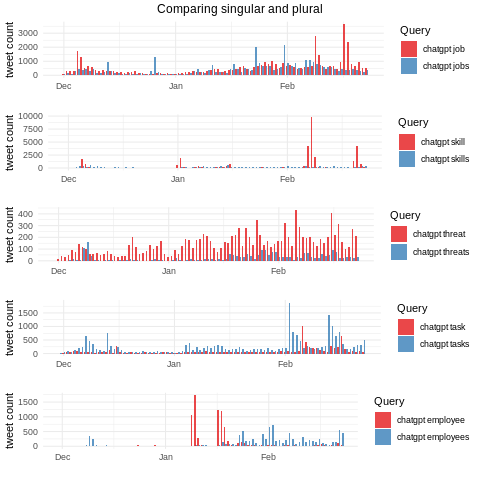

In [2]:
%%R 

library(tidyverse)

query_counts <- read_csv("/content/chatgpt_employment/query_counts.csv")

library(RColorBrewer)

# JOB VS JOBS
p1 <- query_counts %>% 
  filter(str_detect(query, "job")) %>% 
ggplot(aes(x = as.Date(start), y = tweet_count, fill = query)) +
  geom_bar(stat = "identity", alpha = 0.8, position = "dodge") +
  scale_fill_brewer(palette = "Set1", name = "Query")+
  theme_minimal()+
  xlab("")+
  ylab("tweet count") 

# SKILL VS SKILLS
p2 <- query_counts %>% 
  filter(str_detect(query, "skill")) %>% 
  ggplot(aes(x = as.Date(start), y = tweet_count, fill = query)) +
  geom_bar(stat = "identity", alpha = 0.8, position = "dodge") +
  scale_fill_brewer(palette = "Set1", name = "Query")+
  theme_minimal()+
  xlab("")+
  ylab("tweet count")

# THREAT VS THREATS
p3 <- query_counts %>% 
  filter(str_detect(query, "threat")) %>% 
  ggplot(aes(x = as.Date(start), y = tweet_count, fill = query)) +
  geom_bar(stat = "identity", alpha = 0.8, position = "dodge") +
  scale_fill_brewer(palette = "Set1", name = "Query")+
  theme_minimal()+
  xlab("")+
  ylab("tweet count") 

# TASK VS TASKS
p4 <- query_counts %>% 
  filter(str_detect(query, "task")) %>% 
  ggplot(aes(x = as.Date(start), y = tweet_count, fill = query)) +
  geom_bar(stat = "identity", alpha = 0.8, position = "dodge") +
  scale_fill_brewer(palette = "Set1", name = "Query")+
  theme_minimal()+
  xlab("")+
  ylab("tweet count") 

# EMPLOYEE VS EMPLOYEES
p5 <- query_counts %>% 
  filter(str_detect(query, "employee")) %>% 
  ggplot(aes(x = as.Date(start), y = tweet_count, fill = query)) +
  geom_bar(stat = "identity", alpha = 0.8, position = "dodge") +
  scale_fill_brewer(palette = "Set1", name = "Query")+
  theme_minimal()+
  xlab("")+
  ylab("tweet count")

library(grid)
install.packages("gridExtra")
library(gridExtra)
grid.arrange(p1, p2, p3, p4, p5, ncol = 1, top = "Comparing singular and plural")

Following the analysis above, we can tell that there isn't a clear overlap in the number of tweets returned when searching for singular or plural. Furthermore, while at times searching for a singular word returns more results than the plural equivalent, in other instances the opposite is true.

Thus we decided to run a second data collection for the plural form of the words, using the code below.

```
library(tidyverse)
and <- "chatgpt"
or <- c("employees", # post collection insertion
        "jobs", # post collection insertion
        "skills", # post collection insertion
        "concerns", # post collection insertion
        "threats", # post collection insertion
        "occupations", # post collection insertion
        "earnings", # post collection insertion
        "tasks", # post collection insertion
        "collaborations") # post collection insertion

queries <- paste(and, or)

chatgpt_second_collection <- data.frame()
for (i in queries) {
  iteration_i <- get_all_tweets(
    query = i,
    start_tweets = "2022-11-30T00:00:00Z",
    end_tweets = "2023-02-24T00:00:00Z",
    n = Inf,
    bearer_token = bearer_token,
    data_path = "chatgpt_second_collection/")
  iteration_i$query <- i  # Create a new column "query" and assign it the value of i
  chatgpt_second_collection <- bind_rows(chatgpt_second_collection, iteration_i)}

saveRDS(chatgpt_second_collection, "chatgpt_second_collection.RDS")
```



## Summary statistics and characteristics of the data

Upon merging the two datasets, we obtain a total of **548225 tweets**. However, some might be:
- duplicates emerging from counting the same tweet more than once in the event it matched more than one keyword in our query string
- retweets, which means that different users shared the conversation but essentially there is a repetition in textual content

Taking into account the above, we counted that the **unique pieces of text are 191340**. 





In [4]:
%%R
install.packages("jsonlite") # before installing this package you need to restart the runtime, and then re-run the chunk on R magic
library(jsonlite)
first_data <- fromJSON("/content/chatgpt_employment/full_dataset_chatgpt.json") # import first collection
second_data <- fromJSON("/content/chatgpt_employment/second_dataset_chatgpt.json") # import second collection

In [10]:
%%R
library(tidyverse) # need to reimport this library since we restarted the runtime
tweets <- bind_rows(first_data, second_data, .id = "id") # merge datasets
nrow(tweets) # number of tweets including duplicates/retweets

In [19]:
%%R
# keep only unique observations
filtered <- tweets %>%
  group_by(text) %>%
  slice(1) 

nrow(filtered) # 191340 is the number of unique tweets across the two datasets

[1] 191340


### Authors

How many people partake in the conversation?

Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.
`geom_smooth()` using formula = 'y ~ x'


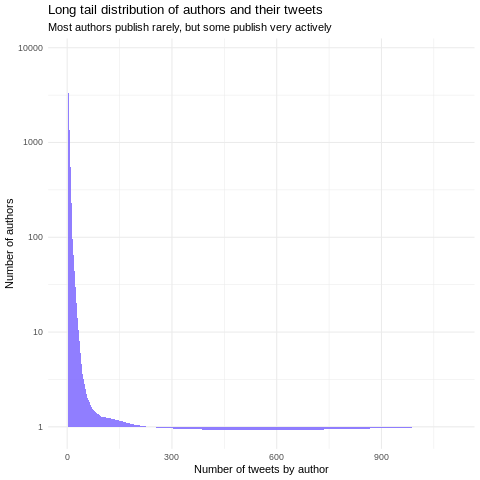

In [73]:
%%R
# how many tweets from the same person have been retweeted?
filtered %>% ungroup() %>% select(author_id) %>% drop_na() %>% count(author_id) %>% count(n) %>%
mutate(tot_authors = sum(nn),
       prop = round(nn/tot_authors*100, 1)) %>%
#filter(n < 150) %>%
  ggplot(aes(x = n, y = nn)) +
  stat_smooth(
    geom = 'area', method = 'loess', span = 1/2,
    alpha = 0.9, fill = "lightslateblue") +
  xlab("Number of tweets by author") +
  ylab("Number of authors")+
  theme_minimal()+
  scale_y_log10()+
  #scale_x_log10()+
  ggtitle("Long tail distribution of authors and their tweets")+
  labs(subtitle = "Most authors publish rarely, but some publish very actively") 

In [82]:
%%R
# top tweeter
top_tweeters <- filtered %>% ungroup() %>% select(author_id) %>% drop_na() %>% count(author_id, sort = desc(TRUE)) %>% slice_head(n = 3) %>% inner_join(filtered, by = "author_id")

In [85]:
%%R

top_tweeters %>% filter(rt == FALSE) # 1163 are not retweets

# A tibble: 1,163 × 8
   author_id               n id    text              query creat…¹ rt    text_…²
   <chr>               <int> <chr> <chr>             <chr> <chr>   <lgl> <chr>  
 1 1551612439397126144   705 1     "@0xWeens Releas… chat… 2023-0… FALSE "@0xWe…
 2 1551612439397126144   705 1     "@0xsequence Rel… chat… 2023-0… FALSE "@0xse…
 3 1551612439397126144   705 1     "@121mcv Release… chat… 2023-0… FALSE "@121m…
 4 1551612439397126144   705 1     "@123trabajo Ver… chat… 2023-0… FALSE "@123t…
 5 1551612439397126144   705 1     "@1911_zmalik @t… chat… 2023-0… FALSE "@1911…
 6 1551612439397126144   705 1     "@1Vip1113131601… chat… 2023-0… FALSE "@1Vip…
 7 1551612439397126144   705 1     "@1phsheth Here … chat… 2023-0… FALSE "@1phs…
 8 1551612439397126144   705 1     "@2_The_Facts Re… chat… 2023-0… FALSE "@2_Th…
 9 1551612439397126144   705 1     "@333years Relea… chat… 2023-0… FALSE "@333y…
10 1551612439397126144   705 1     "@33squared Rele… chat… 2023-0… FALSE "@33sq…
# … wi

In [ ]:
# doing the same for chatgpt full dataset
tweets <- tweets %>%
  mutate(rt = str_detect(text, "RT.*:\\s"))

# visualising
tweets %>% ungroup() %>% select(author) %>% drop_na() %>% count(author, sort = TRUE) %>% slice_head(n = 10) %>%
  ggplot(aes(x = reorder(author, n), y = n)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  ggtitle("Top 10")

filtered %>% count(text_clean) # remove http links

### Timeline

How does the discourse look like over time?